In [1]:
import sys
sys.path.append('../src')

In [2]:
import common.config as cfg
from common.nb_utils import estimate_optimal_ncomponents, pca_transform
from common.utils import get_device, Struct
from data.loader import get_testloader, get_trainloader
import matplotlib.pyplot as plt
from models.fcn import FCN
from models.resnet import resnet18
from models.model_op import get_random_grads, gradient_approximation
from models.svm import SVM
import models.resnet as resnet
import numpy as np
import pickle as pkl
import torch as t
import time
from tqdm.notebook import tqdm

In [3]:
dataset = 'mnist'
input_size = cfg.input_sizes[dataset]
output_size = cfg.output_sizes[dataset]
lr = 1e-1
sdirs_algo = 'pca' # 'qr'
bs = 16
epochs = 20

In [4]:
device = t.device('cuda:2')
loss = t.nn.CrossEntropyLoss().to(device)

In [5]:
trainloader = get_trainloader(dataset, bs, True)
testloader = get_testloader(dataset, bs, True)

In [6]:
sdirs = []
m = 6
n_accum = m*50
for idx in tqdm(range(n_accum)):
    model = resnet.resnet18(num_channels=1, num_classes=output_size).to(device)
    sdirs.append(get_random_grads(model, np.sqrt(n_accum), device))

# pretraining

In [7]:
trainloader = get_trainloader(dataset, 256, False)
testloader = get_testloader(dataset, 256, False)

In [8]:
model = resnet.resnet18(num_channels=1, num_classes=output_size).to(device)
model.load_state_dict(t.load('../ckpts/init/{}_resnet18.init'.format(dataset)))

correcti = 0
x_test = 0
for idx, (data, labels) in enumerate(testloader):
    x, y = data.to(device), labels.to(device)
    y_hat = model(x)
    loss_val = loss(y_hat, y)
    predi = y_hat.argmax(1, keepdim=True)
    correcti += predi.eq(y.view_as(predi)).sum().item()
y_test = correcti/len(testloader.dataset)
x_test, y_test

(0, 0.1046)

# w/o gradient approximation

In [9]:
model = resnet.resnet18(num_channels=1, num_classes=output_size).to(device)
model.load_state_dict(t.load('../ckpts/init/{}_resnet18.init'.format(dataset)))

xb_train, yb_train = [], []
xb_test, yb_test =[], []
for _ in tqdm(range(1, epochs+1), leave=False):
    xb_train.append(_)
    correcti = 0
    for idx, (data, labels) in enumerate(trainloader):
        x, y = data.to(device), labels.to(device)
        optimizer = t.optim.SGD(model.parameters(), lr=lr)
        optimizer.zero_grad()
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        loss_val.backward()
        optimizer.step()
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    yb_train.append(correcti/len(trainloader.dataset))
    
    correcti = 0
    for idx, (data, labels) in enumerate(testloader):
        x, y = data.to(device), labels.to(device)
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    yb_test.append(correcti/len(testloader.dataset))
    print('{} \t {:.4f} \t {:.2f} \t {:.2f}'.format(
        xb_train[-1], loss_val.item(), yb_train[-1], yb_test[-1]
    ))

1 	 0.0005 	 0.95 	 0.98
2 	 0.0002 	 0.99 	 0.99
3 	 0.0000 	 1.00 	 0.99
4 	 0.0001 	 1.00 	 0.99
5 	 0.0000 	 1.00 	 0.99
6 	 0.0000 	 1.00 	 0.99
7 	 0.0000 	 1.00 	 0.99
8 	 0.0000 	 1.00 	 0.99
9 	 0.0000 	 1.00 	 0.99
10 	 0.0000 	 1.00 	 0.99
11 	 0.0000 	 1.00 	 0.99
12 	 0.0000 	 1.00 	 0.99
13 	 0.0000 	 1.00 	 0.99
14 	 0.0000 	 1.00 	 0.99
15 	 0.0000 	 1.00 	 0.99
16 	 0.0000 	 1.00 	 0.99
17 	 0.0000 	 1.00 	 0.99
18 	 0.0000 	 1.00 	 0.99
19 	 0.0000 	 1.00 	 0.99
20 	 0.0000 	 1.00 	 0.99


# gradient approximation using all directions

In [ ]:
model = resnet.resnet18(num_channels=1, num_classes=output_size).to(device)
model.load_state_dict(t.load('../ckpts/init/{}_resnet18.init'.format(dataset)))

xa_train, ya_train = [], []
xa_test, ya_test = [], []
for _ in tqdm(range(1, epochs+1), leave=False):
    start = time.time()
    xa_train.append(_)
    xa_test.append(_)
    correcti = 0
    for idx, (data, labels) in enumerate(trainloader):
        x, y = data.to(device), labels.to(device)
        optimizer = t.optim.SGD(model.parameters(), lr=lr)
        optimizer.zero_grad()
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        loss_val.backward()
        _, error = gradient_approximation(model, sdirs, device, [])
        optimizer.step()
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    ya_train.append(correcti/len(trainloader.dataset))
    
    correcti = 0
    for idx, (data, labels) in enumerate(testloader):
        x, y = data.to(device), labels.to(device)
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    ya_test.append(correcti/len(testloader.dataset))
    print('{} \t {:.4f} \t {:.2f} \t {:.2f}'.format(
        xa_train[-1], loss_val.item(), ya_train[-1], ya_test[-1]
    ))

1 	 0.2591 	 0.74 	 0.89
2 	 0.2993 	 0.91 	 0.93
3 	 0.2589 	 0.93 	 0.94
4 	 0.4914 	 0.95 	 0.95
5 	 0.2466 	 0.95 	 0.95
6 	 0.1877 	 0.96 	 0.96
7 	 0.0325 	 0.97 	 0.96
8 	 0.1537 	 0.97 	 0.96
9 	 0.3799 	 0.97 	 0.96
10 	 0.0206 	 0.97 	 0.96
11 	 0.1862 	 0.98 	 0.97
12 	 0.0062 	 0.98 	 0.97
13 	 0.1191 	 0.98 	 0.97
14 	 0.2681 	 0.98 	 0.97


# gradient approximation using n directions

In [10]:
n = 1
model = resnet.resnet18(num_channels=1, num_classes=output_size).to(device)
model.load_state_dict(t.load('../ckpts/init/{}_resnet18.init'.format(dataset)))

xe_train, ye_train = [], []
xe_test, ye_test = [], []
for _ in tqdm(range(1, epochs+1), leave=False):
    start = time.time()
    xe_train.append(_)
    xe_test.append(_)
    correcti = 0
    for idx, (data, labels) in enumerate(trainloader):
        x, y = data.to(device), labels.to(device)
        optimizer = t.optim.SGD(model.parameters(), lr=lr)
        optimizer.zero_grad()
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        loss_val.backward()
        _, error = gradient_approximation(
            model, 
            [sdirs[idx]], device, [])
        optimizer.step()
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    ye_train.append(correcti/len(trainloader.dataset))
    
    correcti = 0
    for idx, (data, labels) in enumerate(testloader):
        x, y = data.to(device), labels.to(device)
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    ye_test.append(correcti/len(testloader.dataset))
    print('{} \t {:.4f} \t {:.2f} \t {:.2f}'.format(
        xe_train[-1], loss_val.item(), ye_train[-1], ye_test[-1]
    ))

1 	 2.3927 	 0.13 	 0.15
2 	 2.2874 	 0.16 	 0.18
3 	 2.1215 	 0.20 	 0.21
4 	 2.0889 	 0.23 	 0.24
5 	 2.0336 	 0.24 	 0.25
6 	 1.9763 	 0.26 	 0.27
7 	 2.0974 	 0.27 	 0.29
8 	 2.0452 	 0.29 	 0.29
9 	 2.0527 	 0.30 	 0.30
10 	 2.0319 	 0.31 	 0.32
11 	 1.8896 	 0.32 	 0.31
12 	 1.9420 	 0.32 	 0.33
13 	 1.9399 	 0.32 	 0.33
14 	 1.9857 	 0.33 	 0.34
15 	 2.0134 	 0.34 	 0.35
16 	 1.9739 	 0.34 	 0.35
17 	 1.8883 	 0.35 	 0.36
18 	 1.8782 	 0.36 	 0.37
19 	 1.9320 	 0.37 	 0.38
20 	 1.8743 	 0.38 	 0.39


In [11]:
n = 10
model = resnet.resnet18(num_channels=1, num_classes=output_size).to(device)
model.load_state_dict(t.load('../ckpts/init/{}_resnet18.init'.format(dataset)))

xc_train, yc_train = [], []
xc_test, yc_test = [], []
for _ in tqdm(range(1, epochs+1), leave=False):
    start = time.time()
    xc_train.append(_)
    xc_test.append(_)
    correcti = 0
    for idx, (data, labels) in enumerate(trainloader):
        x, y = data.to(device), labels.to(device)
        optimizer = t.optim.SGD(model.parameters(), lr=lr)
        optimizer.zero_grad()
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        loss_val.backward()
        _, error = gradient_approximation(
            model, 
            sdirs[idx: idx+n], device, [])
        optimizer.step()
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    yc_train.append(correcti/len(trainloader.dataset))
    
    correcti = 0
    for idx, (data, labels) in enumerate(testloader):
        x, y = data.to(device), labels.to(device)
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    yc_test.append(correcti/len(testloader.dataset))
    print('{} \t {:.4f} \t {:.2f} \t {:.2f}'.format(
        xc_train[-1], loss_val.item(), yc_train[-1], yc_test[-1]
    ))

1 	 1.9776 	 0.23 	 0.31
2 	 1.5760 	 0.36 	 0.42
3 	 1.8013 	 0.46 	 0.50
4 	 1.3970 	 0.52 	 0.56
5 	 1.3149 	 0.57 	 0.62
6 	 1.1187 	 0.62 	 0.66
7 	 1.0162 	 0.65 	 0.69
8 	 0.8869 	 0.68 	 0.72
9 	 0.9180 	 0.71 	 0.73
10 	 0.7677 	 0.72 	 0.75
11 	 0.8239 	 0.74 	 0.76
12 	 0.8077 	 0.76 	 0.78
13 	 0.7694 	 0.77 	 0.78
14 	 0.7489 	 0.78 	 0.79
15 	 0.7927 	 0.79 	 0.80
16 	 0.6556 	 0.80 	 0.81
17 	 0.6222 	 0.80 	 0.81
18 	 0.5777 	 0.81 	 0.82
19 	 0.6012 	 0.81 	 0.83
20 	 0.5490 	 0.82 	 0.83


In [14]:
n = 100
model = resnet.resnet18(num_channels=1, num_classes=output_size).to(device)
model.load_state_dict(t.load('../ckpts/init/{}_resnet18.init'.format(dataset)))

xd_train, yd_train = [], []
xd_test, yd_test = [], []
for _ in tqdm(range(1, epochs+1), leave=False):
    start = time.time()
    xd_train.append(_)
    xd_test.append(_)
    correcti = 0
    for idx, (data, labels) in enumerate(trainloader):
        x, y = data.to(device), labels.to(device)
        optimizer = t.optim.SGD(model.parameters(), lr=lr)
        optimizer.zero_grad()
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        loss_val.backward()
        _, error = gradient_approximation(
            model, 
            sdirs[idx: idx+n], device, [])
        optimizer.step()
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    yd_train.append(correcti/len(trainloader.dataset))
    
    correcti = 0
    for idx, (data, labels) in enumerate(testloader):
        x, y = data.to(device), labels.to(device)
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    yd_test.append(correcti/len(testloader.dataset))
    print('{} \t {:.4f} \t {:.2f} \t {:.2f}'.format(
        xd_train[-1], loss_val.item(), yd_train[-1], yd_test[-1]
    ))

1 	 0.9657 	 0.54 	 0.73
2 	 0.2066 	 0.79 	 0.84
3 	 0.1581 	 0.86 	 0.88
4 	 0.0790 	 0.89 	 0.90
5 	 0.0336 	 0.90 	 0.91
6 	 0.0153 	 0.92 	 0.92
7 	 0.0128 	 0.92 	 0.93
8 	 0.0154 	 0.93 	 0.93
9 	 0.0072 	 0.94 	 0.93
10 	 0.0054 	 0.94 	 0.94
11 	 0.0054 	 0.95 	 0.94
12 	 0.0055 	 0.95 	 0.94
13 	 0.0046 	 0.95 	 0.94
14 	 0.0038 	 0.95 	 0.95
15 	 0.0025 	 0.95 	 0.95
16 	 0.0033 	 0.96 	 0.95
17 	 0.0028 	 0.96 	 0.95
18 	 0.0025 	 0.96 	 0.95
19 	 0.0027 	 0.96 	 0.95
20 	 0.0040 	 0.96 	 0.95


clf_resnet18_mnist_algo_pca_bs_16_sgd_vs_sgd_approx_random_proj_sampling


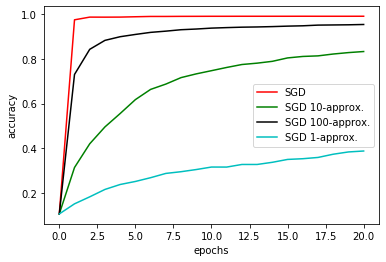

In [15]:
plt.figure()
plt.plot([x_test]+xb_train, [y_test]+yb_test, label='SGD', c='r')
# plt.plot([x_test]+xa_train, [y_test]+ya_test, label='SGD {}-approx.'.format(len(sdirs)), c='b')
plt.plot([x_test]+xc_train, [y_test]+yc_test, label='SGD 10-approx.', c='g')
plt.plot([x_test]+xd_train, [y_test]+yd_test, label='SGD 100-approx.', c='k')
plt.plot([x_test]+xe_train, [y_test]+ye_test, label='SGD 1-approx.', c='c')

history = {
    'test': [x_test, y_test],
#     'a': [xa_train, ya_train, xa_test, ya_test],
    'b': [xb_train, yb_train, xb_test, yb_test],
    'c': [xc_train, yc_train, xc_test, yc_test],
    'd': [xd_train, yd_train, xd_test, yd_test],
    'e': [xe_train, ye_train, xe_test, ye_test],
}

name = 'clf_{}_{}_algo_{}_bs_{}_sgd_vs_sgd_approx_random_proj_sampling'.format(
    'resnet18', dataset, sdirs_algo, bs)
print(name)

pkl.dump(history, open('../ckpts/history/{}.pkl'.format(name), 'wb'))

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig(
    '../ckpts/plots/{}.png'.format(name), 
    dpi=300, bbox_inches='tight'
)

# Comparisons

clf_resnet18_mnist_algo_pca_bs_16_sgd_vs_sgd_approx_comparison


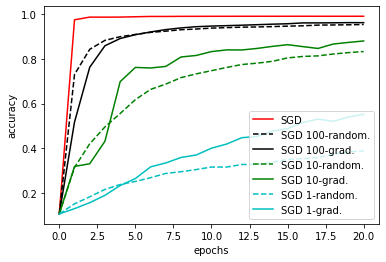

In [16]:
name = 'clf_{}_{}_algo_{}_bs_{}_sgd_vs_sgd_approx_random_proj_sampling'.format(
    'resnet18', dataset, sdirs_algo, bs)

history = pkl.load(open('../ckpts/history/{}.pkl'.format(name), 'rb'))
h = pkl.load(open('../ckpts/history/{}.pkl'.format(name.replace('proj', 'grad')), 'rb'))

plt.figure()
plt.plot([history['test'][0]]+history['b'][0], [history['test'][1]]+history['b'][-1],
         label='SGD', c='r')
plt.plot([history['test'][0]]+history['d'][0], [history['test'][1]]+history['d'][-1], 
         label='SGD 100-random.', c='k', linestyle='--')
plt.plot([h['test'][0]]+h['d'][0], [h['test'][1]]+h['d'][-1], label='SGD 100-grad.', c='k')
plt.plot([history['test'][0]]+history['c'][0], [history['test'][1]]+history['c'][-1], 
         label='SGD 10-random.', c='g', linestyle='--')
plt.plot([h['test'][0]]+h['c'][0], [h['test'][1]]+h['c'][-1], label='SGD 10-grad.', c='g')
plt.plot([history['test'][0]]+history['e'][0], [history['test'][1]]+history['e'][-1], 
         label='SGD 1-random.', c='c', linestyle='--')
plt.plot([h['test'][0]]+h['e'][0], [h['test'][1]]+h['e'][-1], label='SGD 1-grad.', c='c')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
cname = 'clf_{}_{}_algo_{}_bs_{}_sgd_vs_sgd_approx_comparison'.format(
    'resnet18', dataset, sdirs_algo, bs)
print(cname)
plt.savefig(
    '../ckpts/plots/{}.png'.format(cname), 
    dpi=300, bbox_inches='tight'
)